# Finite element for Poisson

In [18]:
import numpy as np
from geometry import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [4]:
# Lagrangian basis functions (and its derivative)
from scipy.interpolate import lagrange

def lagrange_poly(nodes,k):
    interpVal=np.zeros(np.size(nodes))
    interpVal[k] = 1.
    pp=lagrange(nodes,interpVal)
    return pp

def lagrange_basis(nodes,x,k):
    pp=lagrange_poly(nodes,k)
    return pp(x)

def lagrange_deriv(nodes,x,k):
    pp=lagrange_poly(nodes,k)
    dd=pp.deriv()
    return dd(x)

In [59]:
class FEM1D_reference_element:
    def __init__(self, degree, x_nodes =None):
        self.x_left = 0
        self.x_right = 1
        self.degree = degree
        self.n_basis = self.degree+1
        if x_nodes is None:
            self.x_nodes = np.linspace(self.x_left, self.x_right, self.n_basis)
        else:
            self.x_nodes = x_nodes
        if len(self.x_nodes)!=self.n_basis:
            raise ValueError("The length of the input nodes %d should be degree +1= %d"%(len(self.x_nodes,self.n_basis))) 

        # quadrature nodes and weights (are defined on the interval (-1,1)
        self.quad_nodes, self.quad_weights = np.polynomial.legendre.leggauss(self.degree+1)
        self.quad_nodes = (self.quad_nodes+1)/2.*(self.x_right-self.x_left)+self.x_left
        self.quad_weights = self.quad_weights/2.*(self.x_right-self.x_left)


    def eval_basis(self, xx):
        yy = np.zeros((self.n_basis,len(xx)))
        for j in range(self.n_basis):
            yy[j,:]=lagrange_basis(self.x_nodes,xx,j)
        return yy

    def eval_der_basis(self, xx):
        yy = np.zeros((self.n_basis,len(xx)))
        for j in range(self.n_basis):
            yy[j,:]=lagrange_deriv(self.x_nodes,xx,j)
        return yy
    
    def eval_basis_and_deriv_in_quad(self):
        self.basis_in_quad = self.eval_basis(self.quad_nodes)
        self.deriv_in_quad = self.eval_der_basis(self.quad_nodes)
        
    def assemble_stiffness(self):
        if not hasattr(self,"deriv_in_quad"):
            self.eval_basis_and_deriv_in_quad()
        self.stiffness = np.zeros((self.n_basis,self.n_basis))
        for i in range(self.n_basis):
            for j in range(self.n_basis):
                self.stiffness[i,j] = np.sum(self.deriv_in_quad[i,:]*self.deriv_in_quad[j,:]*self.quad_weights)
        return self.stiffness

    def assemble_mass(self):
        if not hasattr(self,"basis_in_quad"):
            self.eval_basis_and_deriv_in_quad()
        self.mass = np.zeros((self.n_basis,self.n_basis))
        for i in range(self.n_basis):
            for j in range(self.n_basis):
                self.mass[i,j] = np.sum(self.basis_in_quad[i,:]*self.basis_in_quad[j,:]*self.quad_weights)
        return self.mass

[[ 0.13333333  0.06666667 -0.03333333]
 [ 0.06666667  0.53333333  0.06666667]
 [-0.03333333  0.06666667  0.13333333]]
[[ 2.33333333 -2.66666667  0.33333333]
 [-2.66666667  5.33333333 -2.66666667]
 [ 0.33333333 -2.66666667  2.33333333]]


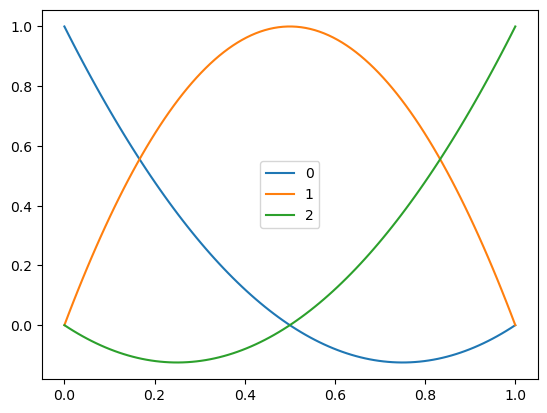

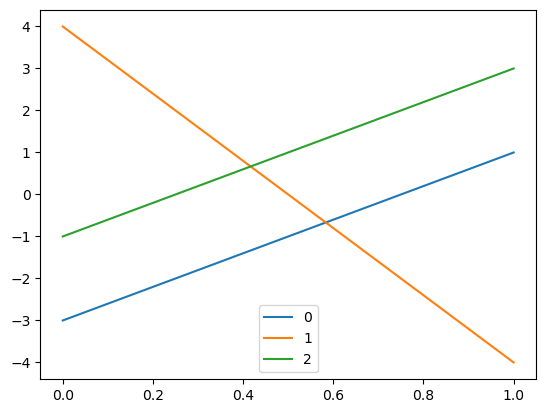

In [61]:
degree=2
fem1d = FEM1D_reference_element(degree)

xx = np.linspace(0,1,100)


plt.figure()
plt.plot(xx,fem1d.eval_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()
plt.savefig("basis_reference_degree_%d.pdf"%(fem1d.degree))
plt.savefig("basis_reference_degree_%d.png"%(fem1d.degree))

plt.figure()
plt.plot(xx,fem1d.eval_der_basis(xx).T, label=np.arange(fem1d.n_basis))
plt.legend()

print(fem1d.assemble_mass())


print(fem1d.assemble_stiffness())

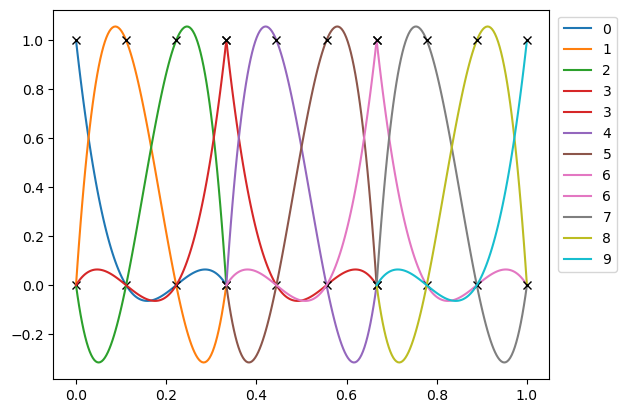

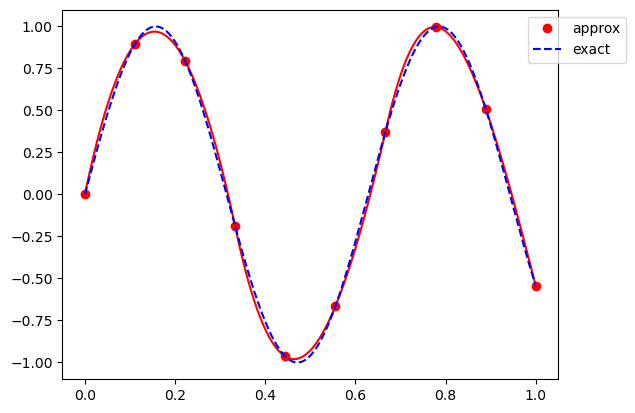

In [58]:
    
class FEM1D:
    def __init__(self,geom, reference_element):
        self.geom = geom
        self.reference_element = reference_element
        self.degree = self.reference_element.degree
        self.N_elem = self.geom.N-1
        self.set_degrees_of_freedom()

    def set_degrees_of_freedom(self):
        self.DoFs        = np.zeros(self.N_elem*self.degree+1)
        self.DoFs_matrix = np.zeros((self.N_elem, self.degree+1))
        self.dxs         = np.zeros(self.N_elem)
        self.elem2dofs   = np.zeros((self.N_elem, self.degree+1), dtype=np.int64)
        for i in range(self.N_elem):
            dx = self.geom.xx[i+1]-self.geom.xx[i]
            self.dxs[i] = dx
            self.DoFs_matrix[i,:] = self.reference_element.x_nodes*dx+self.geom.xx[i]
            self.DoFs[i*self.degree:(i+1)*self.degree+1] = self.DoFs_matrix[i,:]
            self.elem2dofs[i,:] = np.arange(i*self.degree,(i+1)*self.degree+1)
    
    def plot_basis_functions(self):
        colors = list(mcolors.TABLEAU_COLORS.values())
        n_col = len(colors)
        x_plot = np.linspace(self.reference_element.x_left, self.reference_element.x_right,100)
        yy = self.reference_element.eval_basis(x_plot)
        plt.figure()
        for i in range(self.N_elem):
            x_plot_phys = x_plot*self.dxs[i]+self.geom.xx[i]
            for j in range(self.degree+1):
                dof_index = self.elem2dofs[i,j]
                plt.plot(x_plot_phys,yy[j,:],color=colors[dof_index%n_col],
                         label = dof_index)
                plt.plot(self.DoFs_matrix[i,j],1., "xk")
                plt.plot(self.DoFs_matrix[i,j],0., "xk")
        plt.legend(bbox_to_anchor=(1.15, 1.0))
        plt.savefig("basis_functions_N_%d_degree_%d.pdf"%(self.N_elem,self.degree))
        plt.savefig("basis_functions_N_%d_degree_%d.png"%(self.N_elem,self.degree))
    
    def plot_function(self, u_coeff, u_ex_lambda = None):
        x_plot = np.linspace(self.reference_element.x_left, self.reference_element.x_right,100)
        basis_plot = self.reference_element.eval_basis(x_plot)
        plt.figure()
        for i in range(self.N_elem):
            x_plot_phys = x_plot*self.dxs[i]+self.geom.xx[i]
            yy = np.zeros_like(x_plot)
            for j in range(self.degree+1):
                dof_index = self.elem2dofs[i,j]
                yy += u_coeff[dof_index]*basis_plot[j,:]
            plt.plot(x_plot_phys,yy,"-r")
        plt.plot(self.DoFs,u_coeff, "ro", label="approx")

        if u_ex_lambda is not None:
            x_plot = np.linspace(self.geom.x_left, self.geom.x_right, 1000)
            y_plot = u_ex_lambda(x_plot)
            plt.plot(x_plot,  y_plot, "b--", label="exact")
        plt.legend(bbox_to_anchor=(1.15, 1.0))
        plt.savefig("approx_function_N_%d_degree_%d.pdf"%(self.N_elem,self.degree))
        plt.savefig("approx_function_N_%d_degree_%d.png"%(self.N_elem,self.degree))
    
    
# Basis functions
reference_element = FEM1D_reference_element(3)
geom = Geometry1D(0,1,N=4)
fem1d = FEM1D(geom,reference_element)

fem1d.plot_basis_functions()

u_lambda = lambda x : np.sin(10*x)
u_coeff = u_lambda(fem1d.DoFs)
fem1d.plot_function(u_coeff, u_lambda)
    
            